In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot
import seaborn as sns
import numpy as np
import os
from scipy import stats

In [2]:
# Importing dataset
file_path = 'TWO_CENTURIES_OF_UM_RACES.csv'
um_df = pd.read_csv(file_path, low_memory=False)

# Ensure 'Year of event' is an integer (should already be if correctly formatted)
um_df['Year of event'] = pd.to_numeric(um_df['Year of event'], errors='coerce')

# Filter for events between 2000 and 2022
um_df_filtered = um_df[(um_df['Year of event'] >= 2000) & (um_df['Year of event'] <= 2022)]

In [3]:
# Distance-based events dataset
distance_based_events = um_df_filtered[~um_df_filtered['Event distance/length'].str.contains('h')]

# 50km events
events_50km = distance_based_events[distance_based_events['Event distance/length']=='50km']
print(events_50km.head())

   Year of event Event dates           Event name Event distance/length  \
0           2018  06.01.2018  Selva Costera (CHI)                  50km   
1           2018  06.01.2018  Selva Costera (CHI)                  50km   
2           2018  06.01.2018  Selva Costera (CHI)                  50km   
3           2018  06.01.2018  Selva Costera (CHI)                  50km   
4           2018  06.01.2018  Selva Costera (CHI)                  50km   

   Event number of finishers Athlete performance        Athlete club  \
0                         22           4:51:39 h               Tnfrc   
1                         22           5:15:45 h  Roberto Echeverría   
2                         22           5:16:44 h   Puro Trail Osorno   
3                         22           5:34:13 h            Columbia   
4                         22           5:54:14 h      Baguales Trail   

  Athlete country  Athlete year of birth Athlete gender Athlete age category  \
0             CHI                 19

In [4]:
# Step 1: Convert 'Athlete performance' to minutes
def time_to_minutes(time_str):
    """Converts a time string with potential day, hour, minute, and second parts into total minutes."""
    # Check if the input is not a string (e.g., NaN values)
    if not isinstance(time_str, str):
        return 0  # Return 0 or an appropriate default value

    days = hours = minutes = seconds = 0
    # Check for and handle the presence of days
    if 'd' in time_str:
        parts = time_str.split('d')
        days = int(parts[0])
        time_str = parts[1].strip()
    if 'h' in time_str:
        time_str = time_str.replace(' h', '')
    
    parts = time_str.split(':')
    if len(parts) == 3:
        hours, minutes, seconds = map(int, parts)
    elif len(parts) == 2:
        hours, minutes = map(int, parts)
    elif len(parts) == 1 and parts[0]:
        hours = int(parts[0])  # Assuming isolated numbers represent hours

    total_minutes = (days * 24 * 60) + (hours * 60) + minutes + (seconds / 60)
    return total_minutes

events_50km['Performance in Minutes'] = events_50km['Athlete performance'].apply(time_to_minutes)
print(events_50km.head())

   Year of event Event dates           Event name Event distance/length  \
0           2018  06.01.2018  Selva Costera (CHI)                  50km   
1           2018  06.01.2018  Selva Costera (CHI)                  50km   
2           2018  06.01.2018  Selva Costera (CHI)                  50km   
3           2018  06.01.2018  Selva Costera (CHI)                  50km   
4           2018  06.01.2018  Selva Costera (CHI)                  50km   

   Event number of finishers Athlete performance        Athlete club  \
0                         22           4:51:39 h               Tnfrc   
1                         22           5:15:45 h  Roberto Echeverría   
2                         22           5:16:44 h   Puro Trail Osorno   
3                         22           5:34:13 h            Columbia   
4                         22           5:54:14 h      Baguales Trail   

  Athlete country  Athlete year of birth Athlete gender Athlete age category  \
0             CHI                 19

/tmp/ipykernel_191/787466733.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_50km['Performance in Minutes'] = events_50km['Athlete performance'].apply(time_to_minutes)


In [5]:
# Step 2: Group by gender

events_50km_M = events_50km[events_50km['Athlete gender'] == 'M']
events_50km_F = events_50km[events_50km['Athlete gender'] == 'F']

print(events_50km_M.head())
print(events_50km_F.head())

   Year of event Event dates           Event name Event distance/length  \
0           2018  06.01.2018  Selva Costera (CHI)                  50km   
1           2018  06.01.2018  Selva Costera (CHI)                  50km   
2           2018  06.01.2018  Selva Costera (CHI)                  50km   
3           2018  06.01.2018  Selva Costera (CHI)                  50km   
4           2018  06.01.2018  Selva Costera (CHI)                  50km   

   Event number of finishers Athlete performance        Athlete club  \
0                         22           4:51:39 h               Tnfrc   
1                         22           5:15:45 h  Roberto Echeverría   
2                         22           5:16:44 h   Puro Trail Osorno   
3                         22           5:34:13 h            Columbia   
4                         22           5:54:14 h      Baguales Trail   

  Athlete country  Athlete year of birth Athlete gender Athlete age category  \
0             CHI                 19

In [6]:
# Ensure the 'Performance in minutes' column is numeric for both groups
events_50km_M['Performance in Minutes'] = pd.to_numeric(events_50km_M['Performance in Minutes'], errors='coerce')
events_50km_F['Performance in Minutes'] = pd.to_numeric(events_50km_F['Performance in Minutes'], errors='coerce')

# Drop NaN values that may result from conversion errors
events_50km_M = events_50km_M.dropna(subset=['Performance in Minutes'])
events_50km_F = events_50km_F.dropna(subset=['Performance in Minutes'])

# Perform the t-test
t_stat, p_value = stats.ttest_ind(events_50km_M['Performance in Minutes'], events_50km_F['Performance in Minutes'], equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in performance between genders.")
else:
    print("There is no statistically significant difference in performance between genders.")


/tmp/ipykernel_191/4158018079.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_50km_M['Performance in Minutes'] = pd.to_numeric(events_50km_M['Performance in Minutes'], errors='coerce')
/tmp/ipykernel_191/4158018079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_50km_F['Performance in Minutes'] = pd.to_numeric(events_50km_F['Performance in Minutes'], errors='coerce')


T-statistic: -143.2418899271556, P-value: 0.0
There is a statistically significant difference in performance between genders.


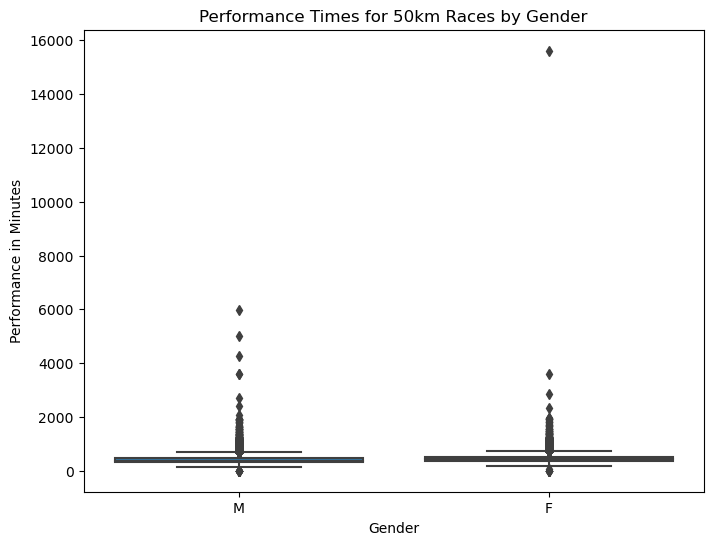

In [7]:
# Combine the DataFrames
events_50km_combined = pd.concat([events_50km_M, events_50km_F])

plt.figure(figsize=(8, 6))
sns.boxplot(x='Athlete gender', y='Performance in Minutes', data=events_50km_combined)
plt.title('Performance Times for 50km Races by Gender')
plt.xlabel('Gender')
plt.ylabel('Performance in Minutes')
plt.show()

<Figure size 960x720 with 0 Axes>

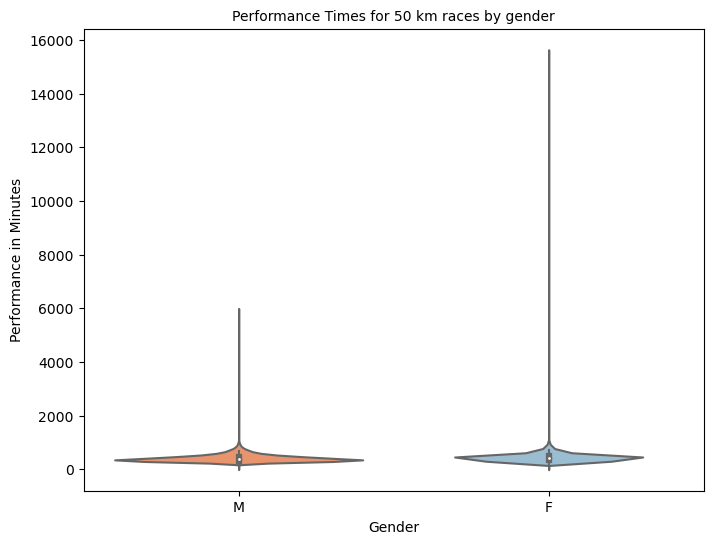

In [8]:
matplotlib.rcParams['figure.dpi']

# Adjust DPI for a new figure
plt.figure(dpi=150)  # Adjust as needed for your display

custom_palette = {
    'M': '#fc8d59',   
    'F': '#91bfdb'  
}
plt.figure(figsize=(8,6))
sns.violinplot(x='Athlete gender', y='Performance in Minutes', data = events_50km_combined,palette=custom_palette)
plt.xlabel('Gender', fontsize='10')
plt.ylabel('Performance in Minutes', fontsize='10')
plt.title('Performance Times for 50 km races by gender', fontsize='10')
# Save the figure with a specific DPI
plt.savefig('figure 6.png', dpi=300)

plt.show()